## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [4]:
import pandas as pd

In [5]:
# место для кода
df = pd.read_csv('data.csv', delimiter=',')

df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
# место для кода
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# место для кода
display(df.groupby(df['Survived']).count())
display(df['Survived'].groupby(df['Pclass']).count())
display(df['Survived'].groupby(df['Sex']).count())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


Pclass
1    216
2    184
3    491
Name: Survived, dtype: int64

Sex
female    314
male      577
Name: Survived, dtype: int64

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset=['Age']), .reset_index(drop=True)`*

In [8]:
# место для кода
df = df.dropna(subset=['Age']).reset_index(drop=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
709,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
710,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
711,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
712,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


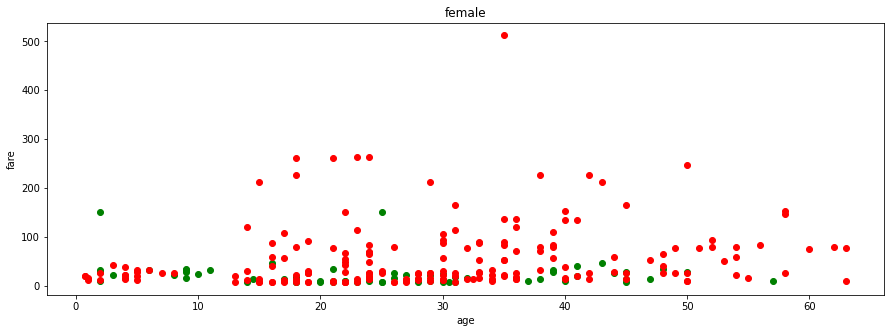

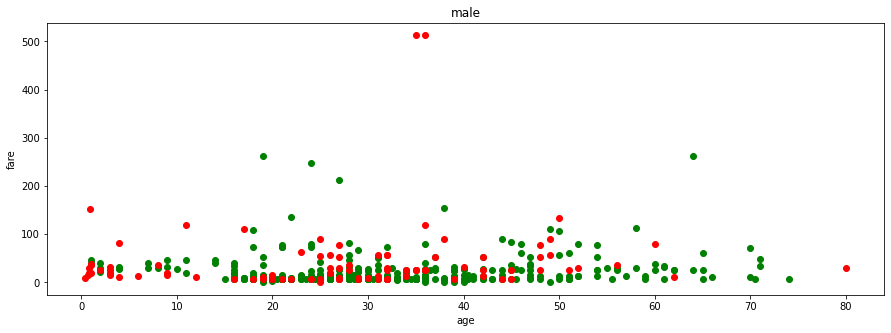

714

In [10]:
# место для кода
surv_t = df['Survived'] == 0
surv_f = df['Survived'] == 1
sex_m = df['Sex'] == 'male'
sex_f = df['Sex'] == 'female'



plt.figure(figsize=(15,5))

plt.scatter(df.loc[surv_t * sex_f, 'Age'], df.loc[surv_t * sex_f, 'Fare'], color = 'green', edgecolors=None)
plt.scatter(df.loc[surv_f * sex_f, 'Age'], df.loc[surv_f * sex_f, 'Fare'], color = 'red', edgecolors=None)

plt.xlabel('age')
plt.ylabel('fare')
plt.title('female')

plt.show()



plt.figure(figsize=(15,5))

plt.scatter(df.loc[surv_t * sex_m, 'Age'], df.loc[surv_t * sex_m, 'Fare'], color = 'green', edgecolors=None)
plt.scatter(df.loc[surv_f * sex_m, 'Age'], df.loc[surv_f * sex_m, 'Fare'], color = 'red', edgecolors=None)

plt.xlabel('age')
plt.ylabel('fare')
plt.title('male')

plt.show()

#проверка
(surv_t * sex_m).sum() + (surv_f * sex_m).sum() + (surv_t * sex_f).sum() + (surv_f * sex_f).sum()

In [11]:
#выполняется ли теория компактности?
#
#для графика для женского пола - нет;
#  класс 'выживших' распределён примерно одинаково среди возрастов, т.е. нет 'скучности',
#  НО если смотреть не по двум данным признакам, а по признаку fare, выжившие лежат очень близко, заисключением двух
#для графика мужского пола - нет
#  ситуация примерна похожая, если рассматривать класс 'невыживших', только разброс по fare сильнее

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [29]:
def distance(a,b):
    #добавим в метрику веса:
    d = 0
    d += 1   *  abs(a['Pclass'] - b['Pclass'])
    d += 1   *  (a['Sex'] != b['Sex'])
    d += 0   *  abs(a['Age'] - b['Age'])
    d += 0   *  abs(a['SibSp'] - b['SibSp'])
    d += 0   *  abs(a['Parch'] - b['Parch'])
    d += 1   *  abs(a['Fare'] - b['Fare'])
    d += 0.5 *  (a['Embarked'] != b['Embarked'])
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [16]:
import numpy as np
import tqdm

In [17]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
            
    dists = sorted(dists, key = lambda pair: pair[0])
    
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1] #* (K-i)/K #добавили линейное убывание 
    prediction /= K
    
    
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [30]:
accuracy = 0
for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    accuracy += row['Survived'] == myKNeighborsClassifier(df, 5, idx)
    
print(accuracy/df.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [01:28<00:00,  8.10it/s]

0.7843137254901961


In [19]:
#сохранённые рез-ты:
#1) def
#   weights:[1, 1, 1, 1, 1, 1, 1],   K = 5  =>  acc=0.726890756302521
#
#2) weights:[1, 1, 0, 0, 0, 1, 0.5], K = 5  =>  acc=0.7843137254901961
#
#3) weights:[1, 2, 2, 2, 2, 1, 0.5], K = 4  =>  acc=0.7408963585434174
#
#4) weights:[1, 2, 2, 2, 2, 1, 0.5], K = 4  =>  acc=0.7408963585434174

In [20]:
'''
max_acc = 0

def distance(a,b):
    d = 0
    d += 1   *  abs(a['Pclass'] - b['Pclass'])
    d += a1  *  (a['Sex'] != b['Sex'])
    d += a2  *  abs(a['Age'] - b['Age'])
    d += a3  *  abs(a['SibSp'] - b['SibSp'])
    d += a4  *  abs(a['Parch'] - b['Parch'])
    d += 1   *  abs(a['Fare'] - b['Fare'])
    d += 0.5 *  (a['Embarked'] != b['Embarked'])
    return d

for K in range(5, 31, 5):
    for a1 in range(2):
        for a2 in range(2):
            for a3 in range(2):
                for a4 in range(2):
                    
                    accuracy = 0
                    for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):
                        accuracy += row['Survived'] == myKNeighborsClassifier(df, K, idx)
                    
                    if accuracy > max_acc:
                        max_acc = accuracy
                        print(accuracy/df.shape[0], a1,a2,a3,a4)
'''

"\nmax_acc = 0\n\ndef distance(a,b):\n    d = 0\n    d += 1   *  abs(a['Pclass'] - b['Pclass'])\n    d += a1  *  (a['Sex'] != b['Sex'])\n    d += a2  *  abs(a['Age'] - b['Age'])\n    d += a3  *  abs(a['SibSp'] - b['SibSp'])\n    d += a4  *  abs(a['Parch'] - b['Parch'])\n    d += 1   *  abs(a['Fare'] - b['Fare'])\n    d += 0.5 *  (a['Embarked'] != b['Embarked'])\n    return d\n\nfor K in range(5, 31, 5):\n    for a1 in range(2):\n        for a2 in range(2):\n            for a3 in range(2):\n                for a4 in range(2):\n                    \n                    accuracy = 0\n                    for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):\n                        accuracy += row['Survived'] == myKNeighborsClassifier(df, K, idx)\n                    \n                    if accuracy > max_acc:\n                        max_acc = accuracy\n                        print(accuracy/df.shape[0], a1,a2,a3,a4)\n"

In [21]:
#print(accuracy)

Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [22]:
# место для кода
def calcMargin(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
            
    dists = sorted(dists, key = lambda pair: pair[0])
    
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    
    
    if (learnData.loc[passengerIndexForPrediction, 'Survived']): #survived
        margin = 2*prediction - 1
    else:
        margin = 1 - 2*prediction    
            
    
    return margin

In [23]:
# место для кода
K = 5
all_margins = np.zeros( len(df) )
# margin   passanger_ind

for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    all_margins[idx] = calcMargin(df, K, idx)
    
print(all_margins)

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [01:27<00:00,  8.16it/s]

[ 1.   0.2 -0.2  0.2  1.   0.2  0.6  0.2  0.6  0.6  0.6  1.   0.6 -0.2
  0.6  0.6  0.6  0.6 -1.   0.2 -0.6  0.6 -0.6 -0.6  0.6  0.6 -0.6  0.2
  1.   0.6  0.6  0.2  0.2 -0.2  0.2  0.6  1.   0.2  0.2  0.6 -0.2  1.
  0.6 -0.6  1.   0.6  0.6 -0.6  1.   1.   1.  -0.2  1.   0.6  1.   0.6
  1.   0.2  1.  -0.6  1.   1.  -0.6  1.   1.  -0.2  1.   0.2  1.   1.
  0.6 -0.2  0.2  1.   0.2 -0.2  1.   0.6 -0.2 -0.6  1.   0.6  1.   0.2
  1.   0.2  0.6  1.   0.2  0.6  0.6  0.6  0.2 -0.2  0.6  0.6 -0.6  0.6
 -0.6  0.6 -1.   0.6  0.6  1.   1.   0.6  0.6  0.2  1.  -0.6  1.   0.2
 -0.2 -0.2  0.6  0.6 -0.2 -0.6  0.6  0.6  0.6  0.6  0.6  1.   1.  -0.2
  0.2  1.   0.6  0.6  0.6  1.   1.  -0.6  1.  -0.6  0.6  0.6  0.2  0.6
 -0.6  0.6  0.2  0.6  0.6 -0.2 -0.2 -1.   0.2  0.6  1.   0.6  0.6 -0.2
 -1.  -0.2  0.2  1.  -1.   0.2  1.   0.6 -1.  -0.2  0.2  0.6  0.2  0.2
  1.  -0.6  1.   0.6  0.2 -0.2  0.2  0.6  0.6 -1.   0.6  1.   0.6  0.6
 -1.   1.   0.6  0.2  0.6  0.6 -0.6  0.6  0.6  1.   0.6  0.2  0.6  0.6
  0.6 -1

In [31]:
# место для кода
all_margins.mean()

0.3798319327731093

In [25]:
sorted_margins = sorted(all_margins)
display(sorted_margins[:10])
display(sorted_margins[-10:])

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [26]:
idx = np.argsort(all_margins)
all_margins[idx]

array([-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
       -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
       -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
       -1. , -1. , -1. , -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0

In [27]:
print('Белые вороны (аномалии)')
df.loc[idx[:5]]

Белые вороны (аномалии)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
162,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,S
343,430,1,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.0500,E10,S
450,570,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,350417,7.8542,NaN,S
347,435,0,1,"Silvey, Mr. William Baird",male,50.0,1,0,13507,55.9000,E44,S
271,339,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S


In [28]:
print('Эталоны (характерные объекты)')
df.loc[idx[-5:]]

Эталоны (характерные объекты)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
573,722,0,3,"Jensen, Mr. Svend Lauritz",male,17.0,1,0,350048,7.0542,NaN,S
302,379,0,3,"Betros, Mr. Tannous",male,20.0,0,0,2648,4.0125,NaN,C
300,377,1,3,"Landergren, Miss. Aurora Adelia",female,22.0,0,0,C 7077,7.2500,NaN,S
539,683,0,3,"Olsvigen, Mr. Thor Anderson",male,20.0,0,0,6563,9.2250,NaN,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S


In [ ]:
#по определению, отрицательный выступ может быть только у тех, кто пресказан неправильно,
#  а если он по модулю большой, то алгоритм 'уверен' в своём неправильно выборе, что помечает данный элемент
#  в рамках рассматриваемого алгоритма 'плохим'.
#напротив же, если отступ сильно положителен, то алгоритм 'уверен' в своём правильном выборе, 
#  эти элементы - хорошие